In [1]:
%matplotlib inline
import glob
import importlib
import uproot
import awkward
import numpy as np
import uproot_methods
import matplotlib.pyplot as plt
import concurrent.futures
import functools
import time
import pandas as pd
from tqdm.auto import tqdm

import utils
import manager
import plotting

importlib.reload(plotting);
importlib.reload(manager);
importlib.reload(utils);

# plotting.bokeh_output_notebook()

## Manager
The manager connects to the redis server/message broker and sends/receives tasks/results.
When not specified in the constructor, the manger takes the redis server url from `config.py`.

In [2]:
m = manager.Manager()
m

<Manager: broker='redis://uaf-1.t2.ucsd.edu:50441', workers=10>

## A "map"
The central idea of a map is to write a single function that gets called for each element in a specified iterable. A `local_map` is nothing more than a regular call to Python's `map`.

The local map below is trivial and takes less than a millisecond.

In [4]:
%%time
def f(x):
    return x**2
m.local_map(f,range(10),progress_bar=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 303 µs


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

## A remote "map"
Now instead of mapping locally, we send the function and arguments to the pool of workers to perform work.

The `remote_map` below has 10 tasks (the arguments are `range(10)`). For each task, we pickle and compress the function + the argument, then push it to a task queue on the message broker.

The workers are constantly waiting for work by listening to the task queue. In a first come, first serve fashion, they pop a single task from the task queue, then uncompress and unpickle the data. They do the equivalent of `f(arg)` and push the compressed output to a results queue on the message broker.

Back in the `Manager`, we listen to the results queue and wait for the results of 10 tasks to come back before returning them to the user.

Notice that we get results back out of order (some workers are closer/faster than others). Also note that the whole process took ~15ms!

In [5]:
%%time
def f(x):
    return x**2
m.remote_map(f,range(10),return_metadata=False,progress_bar=False,skip_payload_check=True)

CPU times: user 11 ms, sys: 2 ms, total: 13 ms
Wall time: 16.8 ms


[0, 64, 4, 9, 1, 81, 49, 36, 16, 25]

### Metadata
We have the option to return the results with metadata as a list of dictionaries. The metadata includes the result, the arguments, a `task_id` (each `remote_map` has a single unique `task_id`), `job_num` (index of each job within the single `remote_map`), metrics for bytes read/written, timestamps before and after the function was called, and most importantly, the name of the worker that processed the task. 

We can always recover the cleaner output of the previous cell with something like `[r["result"] for r in results]`.

In [6]:
results = m.remote_map(f,range(2),return_metadata=True,progress_bar=False)
results

[{'args': 0,
  'job_num': 0,
  'read_bytes': 0,
  'result': 0,
  'task_id': '7429877b345644ac',
  'tstart': 1567214875.153294,
  'tstop': 1567214875.1532984,
  'worker_name': 'namin__cabinet-0-0-10.t2.ucsd.edu__10191605.8',
  'write_bytes': 0},
 {'args': 1,
  'job_num': 1,
  'read_bytes': 0,
  'result': 1,
  'task_id': '7429877b345644ac',
  'tstart': 1567214875.147986,
  'tstop': 1567214875.1479907,
  'worker_name': 'namin__sdsc-84.t2.ucsd.edu__10191605.1',
  'write_bytes': 0}]

## A slightly more useful example
Below, we take some NanoAOD files and return the mean `MET_pt` over each file. Each worker gets one file, and we capped it at 30 total files since we only have a handful of workers for the example.

In [11]:
fnames = glob.glob("/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run201*-Nano1June2019*/*.root")
def f(fname):
    return uproot.open(fname)["Events"].array("MET_pt").mean()
results = m.remote_map(f,fnames[:30],return_metadata=True)

### Monitoring
#### Time flow
OK, so that took less than a minute. What were the workers doing? Using the results containing metadata, we can plot blocks of time during which each worker was performing work. Gaps indicate deadtime.

The efficiency noted on the plot is an indication of the "packing ratio" of blocks within the full rectangle. One of the tasks near the end took a longer time to run than the rest, so there was no more work to perform while we were waiting for it, hence the whitespace at the end. However, the deadtime between tasks ("mean intertask time") is small compared to the length of each task.

Optionally, you can use `bokeh` to get an interactive plot with more details.

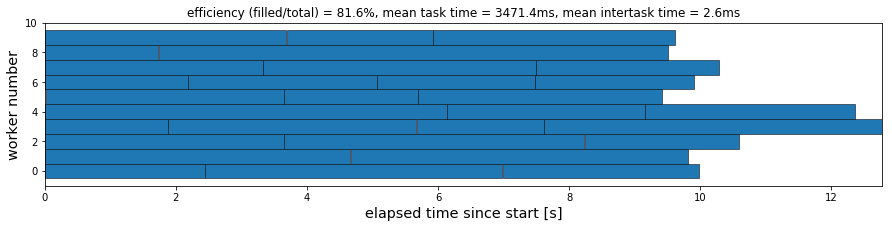

In [12]:
# plotting.plot_timeflow_bokeh(results)
plotting.plot_timeflow(results)

#### I/O over time
We can also plot the bytes read over time

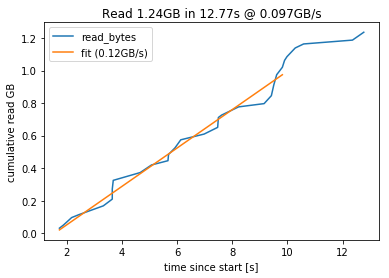

In [13]:
plotting.plot_cumulative_read(results)

## An even more useful example
Now we take some NanoAOD and "chunk" it, to get a list of (filename, startevent, stopevent) triplets, which
will be the arguments we will map over. So instead of using exactly 1 file per worker, we can split more finely by event counts.

In [14]:
%%time
fnames = sorted(glob.glob("/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run*/*.root"))[:50]

chunks, total_nevents = utils.get_chunking(tuple(fnames),int(1.0e6))
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

113 chunks of 50 files, with a total of 8.9124e+07 events
CPU times: user 7.08 s, sys: 363 ms, total: 7.44 s
Wall time: 2.12 s


Let's calculate the invariant mass of OS dimuons with muons passing some isolation and pT cuts.
We do not want to return the raw mass information directly back to the user. The idea of the message broker is to pass only lightweight messages. We instead will histogram the masses and return the bin counts to the user.

In [15]:
def get_mll_hist(args):
    fname,entrystart,entrystop = args
    """
    return 
    - event count considered
    - array of histogram bin counts for m(mumu) for nmu==2 events
    """
    try:
        worker = get_worker()
        cache = worker.cache
    except:
        cache = None
    f = uproot.open(fname)
    t = f["Events"]
    extra = dict(outputtype=tuple,namedecode="ascii",entrystart=entrystart,entrystop=entrystop,cache=cache)
    p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        *t.arrays(["Muon_pt","Muon_eta","Muon_phi","Muon_mass"],**extra)
    )
    charge,mediumid,reliso = t.arrays(["Muon_charge","Muon_mediumId","Muon_pfRelIso04_all"],**extra)
    mus = awkward.JaggedArray.zip(p4=p4,charge=charge,mediumid=mediumid,reliso=reliso)
    nevents = len(mus)
    # retain MUONS passing ID/iso and min pt
    mus = mus[mus.mediumid & (mus.reliso < 0.35) & (mus.p4.pt>=7)]
    # retain EVENTS with 2 muons
    mus = mus[mus.counts==2]
    # retain EVENTS with muons of pt>15 chargesum=0
    mus = mus[(mus[:,0].p4.pt>15.) & (mus[:,1].p4.pt>15.) & (mus[:,:2].charge.sum()==0)]
    mll = (mus[:,0]+mus[:,1]).p4.mass
    bins = np.linspace(50,400,100)
    counts,_ = np.histogram(np.clip(mll,bins[0],bins[-1]),bins=bins)
    return counts

# run the function locally first, so if it crashes, we know not to submit them remotely
get_mll_hist(chunks[0]);

Take note of the `reuse_chunking=True`. This will be important for caching purposes later.

In [16]:
%%time
results = m.remote_map(get_mll_hist,chunks,reuse_chunking=True,return_metadata=True)


CPU times: user 862 ms, sys: 128 ms, total: 990 ms
Wall time: 2min 43s


We make the same plots as before, except now we have a "# of events processed vs time" plot.
This is calculated from the chunk boundaries.

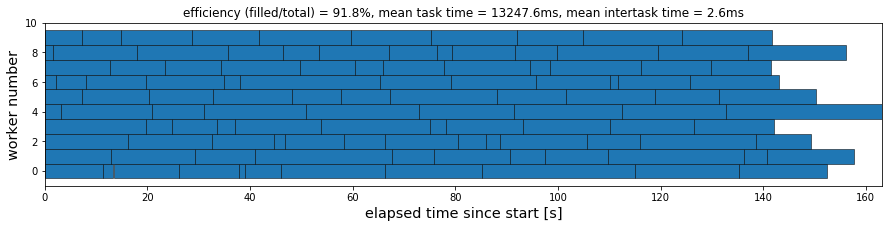

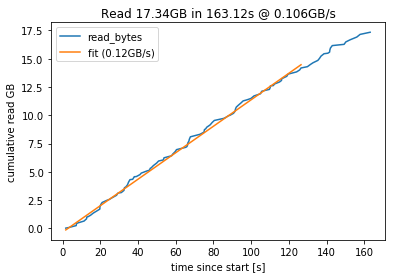

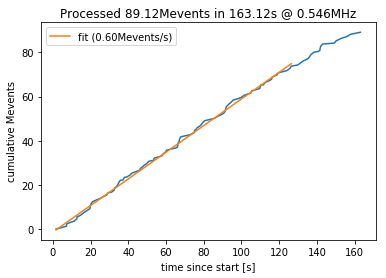

In [17]:
plotting.plot_timeflow(results)
plotting.plot_cumulative_read(results)
plotting.plot_cumulative_events(results)

And here's the histogram of Z's.

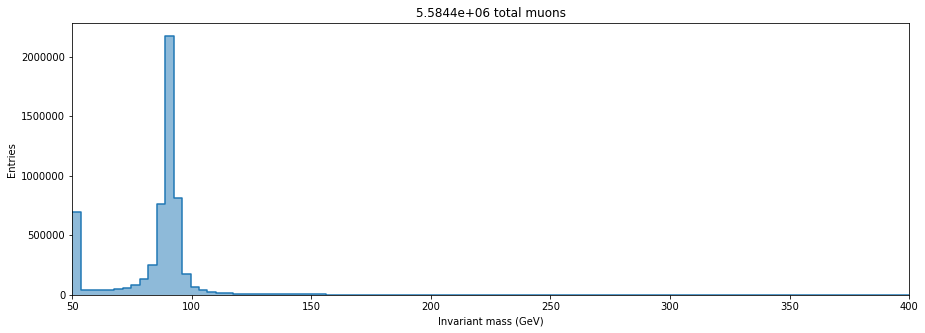

In [18]:
bins = np.linspace(50,400,100)
counts = sum(r["result"] for r in results)
fig,ax = plt.subplots(figsize=(15,5))
ax.step(x=bins, y=np.append(counts,0), where="post")
ax.fill_between(x=bins, y1=np.append(counts,0), step="post",alpha=0.5)
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel("Invariant mass (GeV)")
ax.set_title("{:.5g} total muons".format(counts.sum()))
ax.set_ylabel("Entries");

### Caching
It would be a waste read those branches from disk for one map, and then have to do it again
if we update the function adding in one extra branch. We actually cached the branches when reading the first time with this code:
```python
    try:
        worker = get_worker()
        cache = worker.cache
    except:
        cache = None
    # t.array(..., cache=cache)
```
Locally, the `get_worker()` function does not exist, so we're not caching anything. On the workers, this will return the worker class instance on which we have embedded a `cache` object when starting up the workers. Right now, it's an `uproot.ArrayCache("8 GB")` object, which caches up to 8GB worth of branches into RAM on each worker.

If we were to submit our map again without changing anything, we can't guarantee that the same file/event range will go to the same worker, and so we might not even end up using the cache. The `reuse_chunking=True` option will see if the specified chunks match those from a previous `remote_map` and if so, we will submit tasks to the same workers used in the previous `remote_map`.

In [19]:
%%time
results = m.remote_map(get_mll_hist,chunks,reuse_chunking=True,return_metadata=True)

Current chunking matches old chunking, so we will re-use the old worker ordering to make use of caching



CPU times: user 519 ms, sys: 70 ms, total: 589 ms
Wall time: 24.2 s


Running again, we see a speedup of almost an order of magnitude because we're not reading branches from disk anymore.

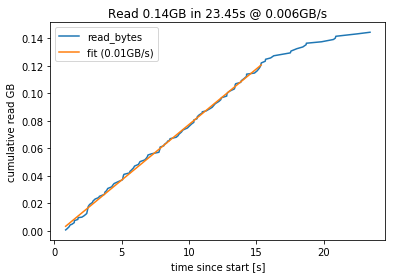

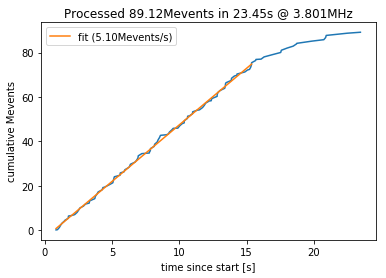

In [20]:
plotting.plot_timeflow_bokeh(results)
plotting.plot_cumulative_read(results)
plotting.plot_cumulative_events(results)